A brief summary of our project

Our team have chosen to reproduce the "[Learning to See in the Dark](https://arxiv.org/pdf/1805.01934.pdf)" paper from 2018. The paper was a big step towards better low light photography. After few months it came out Google presented Night Mode and a lot of manufacturers followed. 

Imaging in low light is challenging due to low signal to noise ratio. Short exposure images suffer from noise, while long exposure images suffer from blurriness. Using high ISO introduces a lot of noise and using a wider aparture is often not possible since it is hardware constrained. The team created a dataset of short exposure images with corresponding long exposure images. [It is freely available here ](https://https://github.com/cchen156/Learning-to-See-in-the-Dark). Then they trained a CNN on the RAW images. Some techniques use multiple images and combine them to extract the most information. This method only uses a single image to construct the final product.

The See in the Dark dataset contains over 5000 images. This does not sound too many, however since they are RAW images the dataset is over 75GB compressed. Because of this we can not really download it to a colab notebook. The images are not realy interesting, just black rectangles since the images were taken in such low light conditions. They were taken with an exposure between 1/10 and 1/30 of a second. The gound truth images are taken between 10s and 30s. Meaning a 100 to 300 longer exposure, or 7 to 9 stops. The images are 4240×2832 or 6000×4000. So passing through a whole image is extemely memory intensive. They used patches of 512x512 and applied random flipping or rotations. The network architecure used are [CAN](https://arxiv.org/pdf/1709.00643.pdf) and [U-net](https://https://arxiv.org/pdf/1505.04597.pdf). These fully convolutional networks (or FCNs) consist of an encoder and decoder part. They have found no difference between L1 and L2 loss functions so we will be using L2. We are only using the smaller dataset. This should not decrease performance, since the original research too only used one dataset to train their model. Meaning they trained two different models for each camera (Sony and a Fuji).

We are using a Google Cloud instance with a GPU. Set up by Mészáros Gergő.

We are planing on optimizing the algorithm by using a smaller FCN. We do not expect our results to match theirs since we do not have that many computing power or their expertise. We do hope to create a smaller network capable of creating images comparable but slightly worse quality however much faster. Our goal is to achive real time speeds. One promising encoder-decoder network we plan on trying is the [SegNet](https://https://mi.eng.cam.ac.uk/projects/segnet/). This network architecture features [batch normalization](https://https://arxiv.org/pdf/1502.03167.pdf) which can not be found in U-net. Batch normalization should [speed up learning.](https://https://arxiv.org/pdf/1607.06450.pdf) We may need to reduce complexity due to computational constraints. 


The paper leaves room for improvement. One of the problems of their model is that the amplifictaion ratio must be choosen externaly. The amplification ratio scales the brightness of the image to a desired value. So it would be useful to infer it from the input image. 

This summary was compiled by Takáts Bálint

The data

We downloaded only the Sony dataset for reasons mentioned above.
After download we unzipped it. The whole folder is over 60GB unzipped.

In [2]:
import zipfile

path = "/home/meszaros_g99/dataset/Sony.zip"
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall("/home/meszaros_g99/dataset")

The authors were nice enough to provide the dataset extremely well organised. They even provided a train-validation and test split. 

In [31]:
import os

trainPath = "/home/meszaros_g99/dataset/Sony_train_list.txt"
testPath = "/home/meszaros_g99/dataset/Sony_test_list.txt"
valPath = "/home/meszaros_g99/dataset/Sony_val_list.txt"
replaceString = "/home/meszaros_g99/dataset"
trainFile = open(trainPath)
for i in range(10):
    print(trainFile.readline())
trainFile.close()

./Sony/short/00001_00_0.04s.ARW ./Sony/long/00001_00_10s.ARW ISO200 F8

./Sony/short/00001_00_0.1s.ARW ./Sony/long/00001_00_10s.ARW ISO200 F8

./Sony/short/00001_01_0.04s.ARW ./Sony/long/00001_00_10s.ARW ISO200 F8

./Sony/short/00001_01_0.1s.ARW ./Sony/long/00001_00_10s.ARW ISO200 F8

./Sony/short/00001_02_0.1s.ARW ./Sony/long/00001_00_10s.ARW ISO200 F8

./Sony/short/00001_03_0.1s.ARW ./Sony/long/00001_00_10s.ARW ISO200 F8

./Sony/short/00001_04_0.1s.ARW ./Sony/long/00001_00_10s.ARW ISO200 F8

./Sony/short/00001_05_0.1s.ARW ./Sony/long/00001_00_10s.ARW ISO200 F8

./Sony/short/00001_06_0.1s.ARW ./Sony/long/00001_00_10s.ARW ISO200 F8

./Sony/short/00001_07_0.1s.ARW ./Sony/long/00001_00_10s.ARW ISO200 F8



The text files contain over a 1000 lines.
Each line has 4 parts: The path to the input image, the path to the ground truth image, ISO it is shot at, and aparture.

In [32]:
trainData = []
with open(trainPath) as File:
    for line in File:
        data, truth, _, _ = line.split()
        data = data.replace(".", replaceString, 1)
        truth = truth.replace(".", replaceString, 1)
        # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
        trainData.append([data, truth])
print (len(trainData))        

1865


In [33]:
testData = []
with open(testPath) as File:
    for line in File:
        data, truth, _, _ = line.split()
        data = data.replace(".", replaceString, 1)
        truth = truth.replace(".", replaceString, 1)
        # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
        testData.append([data, truth])
print (len(testData))  

598


In [34]:
valData = []
with open(valPath) as File:
    for line in File:
        data, truth, _, _ = line.split()
        data = data.replace(".", replaceString, 1)
        truth = truth.replace(".", replaceString, 1)
        # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
        # If we had much more data we would consider reserveing the memory first.
        valData.append([data, truth])
print (len(valData))  

234


In [74]:
print(trainData[0][0])
print(trainData[0][1])

/home/meszaros_g99/dataset/Sony/short/00001_00_0.04s.ARW
/home/meszaros_g99/dataset/Sony/long/00001_00_10s.ARW


In [36]:
!pip3 install --upgrade rawpy

    100% |████████████████████████████████| 686kB 1.9MB/s eta 0:00:01


In [91]:
import rawpy
import numpy as np

# We shamelessly stole their code since we do not dare to say that we understand RAW or Bayer images 
def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    return out

raw = rawpy.imread(trainData[0][0])
input_full = np.expand_dims(pack_raw(raw), axis=0)

print(input_full.shape)

(1, 1424, 2128, 4)


The pictures are 1424 by 2128 by 4. Meaning they are 4 channel images. This will introduce some problems trying to plot them because pyplot only supports RGB images.

In [43]:
!pip3 install --upgrade matplotlib

    100% |████████████████████████████████| 11.6MB 126kB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 10.8MB/s ta 0:00:01
    100% |████████████████████████████████| 163kB 7.4MB/s eta 0:00:01
    100% |████████████████████████████████| 2.2MB 637kB/s eta 0:00:01


(1424, 2128, 4)
(1424, 2128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


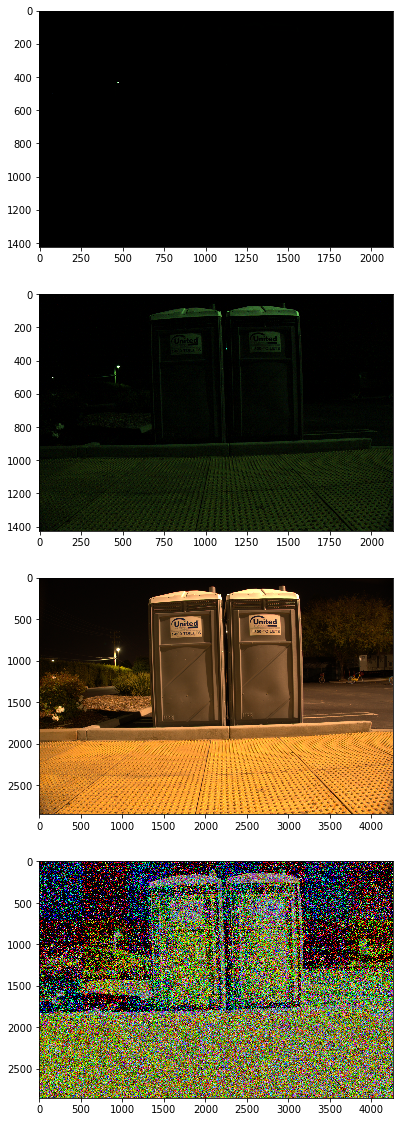

In [102]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dataInput = input_full.reshape(1424, 2128, 4)
print(dataInput.shape)
# The last dimension is discarded so it can be displayed as an RGB image. Due to this colour informaiton is lost and 
# the ploted image has a green tint
dataInput = dataInput[:,:,0:3]
print(dataInput.shape)

raw = rawpy.imread(trainData[0][1])
#postprocessing is needed to show the images using pyplot since it can only handle RGB pictures
dataBase = raw.postprocess()

raw = rawpy.imread(trainData[0][0])
#postprocessing is needed to show the images using pyplot since it can only handle RGB pictures
dataInputScaled = raw.postprocess()

fig, axes = plt.subplots(4,1, figsize=(20,20))
axes[0].imshow(dataInput, interpolation='nearest')
axes[1].imshow(dataInput*100, interpolation='nearest')
axes[2].imshow(dataBase, interpolation='nearest')
axes[3].imshow(dataInputScaled*100, interpolation='nearest')
#plt.imshow()
plt.show()


Plotting these images is a real challange since they are not conventional RGB images. They are RAW images, meaning they have 4 channels. The first two are images from a numpy array with the last dimension discarded. 
The third image is the ground truth postprocessed so it was converted to RGB.
The fourth is the 1st image converted to RGB so none of the colours are lost (like on the 1st and 2nd image) and scaled by a factor of 100. It is quite unusable due to noise

(12121088, 1)


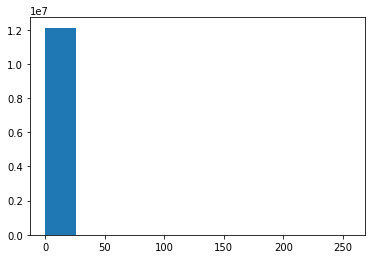

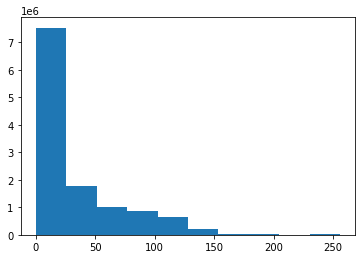

In [113]:
array = input_full.reshape(-1,1)
print(array.shape)
plt.hist(array*256)
plt.show()
plt.hist(np.expand_dims(pack_raw(rawpy.imread(trainData[0][1])), axis=0).reshape(-1,1)*256)
plt.show()

The histogram of the training image is not too usefull. The whole image is dominated by black pixels so the histogram is not very informative. 
The ground truth is still dominated by dark pixels as expected in a dark enviroment.

In [124]:
import math
import collections

dic = {}
for i in array:
    i = math.floor(i * 256)
    if i in dic:
        dic[i] = dic[i] + 1
    else:
        dic[i] = 1

In [126]:
dic = collections.OrderedDict(sorted(dic.items()))
for i in dic:
    print(str(i) + "\t" + str(dic[i]) )

0	12106576
1	13245
2	459
3	69
4	50
5	46
6	30
7	26
8	19
9	28
10	26
11	23
12	17
13	15
14	6
15	13
16	14
17	14
18	11
19	5
20	11
21	9
22	7
23	9
24	4
25	9
26	13
27	4
28	7
29	4
30	2
31	8
32	3
33	7
34	6
35	6
36	4
37	4
38	2
39	3
40	4
41	3
42	1
43	2
44	4
45	4
46	5
47	3
48	2
49	3
51	1
52	1
53	2
54	3
55	1
57	5
58	1
59	3
60	1
61	3
62	3
63	1
64	1
65	6
66	1
67	1
68	1
69	1
70	3
72	4
75	1
76	2
77	3
79	2
80	1
81	1
82	1
83	4
84	3
85	1
87	2
88	1
90	1
93	2
94	1
95	5
96	1
97	1
101	2
102	2
103	1
104	1
106	1
107	2
108	2
110	1
111	1
113	1
114	2
116	1
117	1
118	1
121	1
122	1
123	1
124	2
129	1
130	2
132	2
133	3
134	2
135	1
136	2
137	1
139	1
140	1
141	4
146	3
148	1
149	1
151	1
156	1
157	1
162	2
168	1
173	3
174	2
175	1
179	1
180	1
181	1
182	1
191	1
192	1
195	2
196	1
199	1
201	1
202	1
203	1
207	1
210	1
212	1
214	2
216	2
218	1
220	1
227	1
230	1
232	1
233	1
237	1
239	1
241	1
244	1
246	1
247	1
249	2
251	2
256	70


I did not expect this at all. Almost all of the pixels are pitch black, to be precise 99.88% of them. Of course a ton of detail is lost due to math.floor() but still quite surprising. 

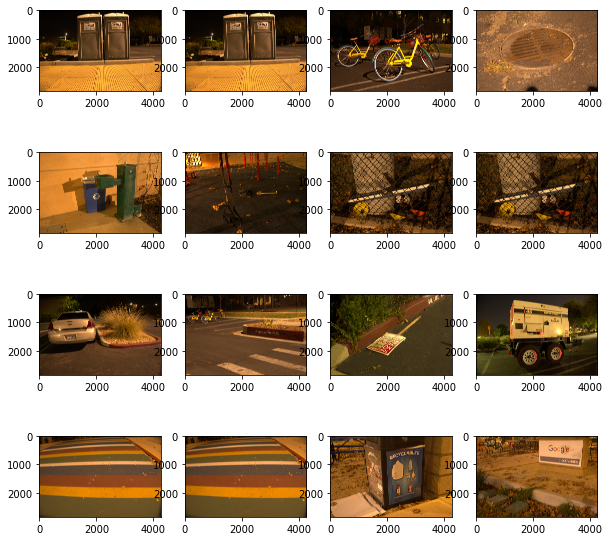

In [128]:
index = 1
fig, axes = plt.subplots(4,4, figsize=(10,10))
for row in axes:
    for col in row:
        raw = rawpy.imread(trainData[index][1])
        #postprocessing is needed to show the images using pyplot since it can only handle RGB pictures
        temp = raw.postprocess()
        col.imshow(temp)
        index = index + 10 

The index is not incremented by 1. This is done to showcase different ground truth images.
There are multiple images that have the same ground truth pair. Meaning they took multiple photos of the same place and then one long exposure one.

Visualization was done by Takáts Bálint.